In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random, jit, jacfwd, vmap
from jax.numpy.linalg import inv
from jax.nn import tanh, sigmoid

from scipy.optimize import minimize
from scipy.stats import norm

import matplotlib.pyplot as plt

np.random.seed(1)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-khni8whc because the default path (/home/jaron/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


2024-02-25 12:22:57.668957: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


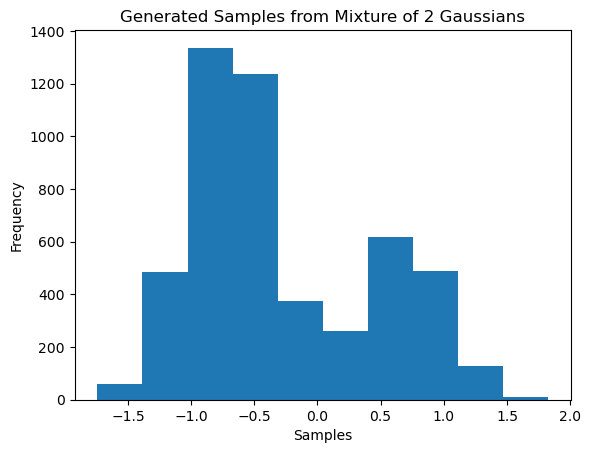

In [2]:
# Chat GPT generated code to sample from mixture of 2 2-dimensional Gaussians

# Generate samples from a 2-dimensional mixture of 2 Gaussians.
def generate_samples(num_samples, means, covariances, weights):
    num_components = len(means)

    # Choose components for each sample based on the weights
    component_choices = np.random.choice(num_components, size=num_samples, p=weights)

    # Generate samples for each component
    samples = np.zeros((num_samples, len(means[0])))

    for i in range(num_components):
        component_samples = np.random.multivariate_normal(means[i], covariances[i], size=num_samples)
        mask = (component_choices == i)
        samples[mask, :] = component_samples[mask, :]

    return samples

# Example usage:
# Set up parameters for two Gaussians
mean1 = np.array([-.7])
covariance1 = np.array([[.1]])
precision1 = inv(covariance1)
weight1 = .7

mean2 = np.array([.7])
covariance2 = np.array([[.1]])
precision2 = inv(covariance2)
weight2 = .3

# Generate synthetic data
num_samples = 5000
means = [mean1, mean2]
covariances = [covariance1, covariance2]
weights = [weight1, weight2]
generated_samples = generate_samples(num_samples, means, covariances, weights)

plt.hist(generated_samples.ravel())
plt.title('Generated Samples from Mixture of 2 Gaussians')
plt.xlabel('Samples')
plt.ylabel('Frequency')
plt.show()

In [3]:
# goal is to use a neural network to map Gaussian noise to samples from posterior parameter distribution

In [4]:
# problem dimension
d = 1

# neural net dimension
h1 = 16
# h2 = 2
# h3 = 2

# determine shapes of weights/biases = [Wih, bih, Who, bho]
# shapes = [[h1, d], [h1], [h2, h1], [h2], [h3, h2], [h3], [d, h3], [d]]
shapes = [[h1, d], [h1], [d, h1], [d]]
k_params = []
n_params = 0
for shape in shapes:
    k_params.append(n_params)
    n_params += np.prod(shape)
k_params.append(n_params)

# initialize parameters
lmbda = np.zeros(n_params)
for k1,k2,shape in zip(k_params, k_params[1:], shapes):
    if len(shape)>1:
        stdv = 2./np.sqrt(2*shape[-1])
        lmbda[k1:k2] = np.log2(np.random.uniform(0., stdv, k2-k1,))
    else:
        lmbda[k1:k2] = np.random.randn(k2-k1,) / np.sqrt(2.)
    
# reshape parameters into weight matrices and bias vectors
def reshape(params):
    # params is a vector = [Wih, bih, Who, bho]
    return [np.reshape(params[k1:k2], shape) for k1, k2, shape in
            zip(k_params, k_params[1:], shapes)]

@jit
def nn(y, lmbda):
    
    # weights and biases of nn
    W1, b1, W4, b4 = reshape(lmbda)
    
    # hidden layer
    h = tanh(jnp.einsum('ij,...j->...i', jnp.exp2(W1), y) + b1)
    
    # hidden layer
    # h = tanh(jnp.einsum('ij,...j->...i', jnp.exp2(W2), h) + b2)
    
    # hidden layer
    # h = tanh(jnp.einsum('ij,...j->...i', jnp.exp2(W3), h) + b3)
    
    # output
    z = jnp.einsum('ij,...j->...i', jnp.exp2(W4), h) + b4
    
    return z

# gradient of nn output w.r.t. parameters
grad_nn = jit(jacfwd(nn, 1))

# @jit 
# def inv_nn(z, lmbda):
    
#     # weights and biases of nn
#     W1, b1, W3, b3 = reshape(lmbda)
    
#     # hidden layer
#     h = jnp.einsum('ij,...j->...i', inv(W3), z - b3)
    
#     # input 
#     # h = jnp.einsum('ij,...j->...i', inv(W2), jnp.arctanh(h) - b2)
    
#     # input 
#     y = jnp.einsum('ij,...j->...i', inv(W1), jnp.arctanh(h) - b1)

#     return y 
    
# gradient of nn output w.r.t. parameters
jac_nn = jit(jacfwd(nn, 0))
# jac_inv_nn = jit(jacfwd(inv_nn, 0))

@jit
def log_abs_det(yi, lmbda):
    return jnp.log(jnp.abs(jnp.linalg.det(jac_nn(yi, lmbda))))

# gradient of entropy of approximating distribution w.r.t. lmbda
grad_log_abs_det = jit(jacfwd(log_abs_det, 1))

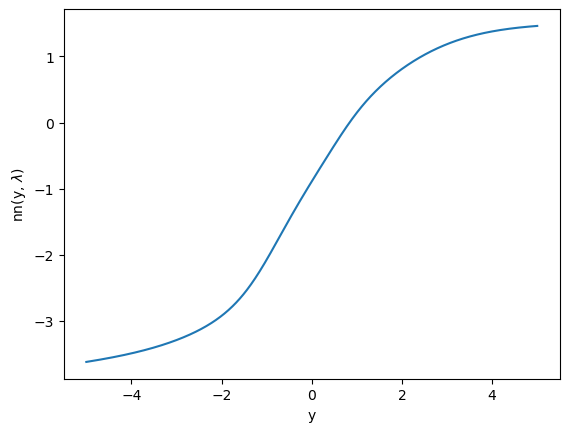

In [5]:
y = np.vstack(np.linspace(-5, 5, 1000))
z = nn(y, lmbda)

plt.plot(y.ravel(), np.array(z.ravel()))
plt.xlabel('y')
plt.ylabel('nn(y, $\lambda$)')
plt.show()

In [6]:
# nll of true posterior
@jit 
def neg_log_likelihood(yi, lmbda):
    zi = nn(yi, lmbda)
    # l1 = weight1 * N(zi | m1, C1)
    # l2 = weight2 * N(zi | m2, C2)
    l1 = weight1 * 1./((2.*jnp.pi)**(d/2.)) * (1./jnp.sqrt(jnp.linalg.det(covariance1))) * jnp.exp(-jnp.einsum('i,ij,j', zi-mean1, precision1, zi-mean1) / 2.)
    l2 = weight2 * 1./((2.*jnp.pi)**(d/2.)) * (1./jnp.sqrt(jnp.linalg.det(covariance2))) * jnp.exp(-jnp.einsum('i,ij,j', zi-mean2, precision2, zi-mean2) / 2.)
    return -jnp.log(l1 + l2)
grad_neg_log_likelihood = jit(jacfwd(neg_log_likelihood, 1))

# kl divergence btw q(lmbda) and p(z | X)
def kl(lmbda, n_sample=10):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    z = nn(y, lmbda)
    
    # evaluate model fitness 
    KL = 0.
    for yi, zi in zip(y, z):
        # divergence btw true posterior
        KL += neg_log_likelihood(yi, lmbda) / n_sample
        # entropy
        KL -= log_abs_det(yi, lmbda) / n_sample
        
    return KL

# make sure NN is flexible enough to capture true posterior
def grad_kl(lmbda, n_sample=10):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    z = nn(y, lmbda)
    
    grad_KL = 0.
    for yi, zi in zip(y, z):
        grad_KL += grad_neg_log_likelihood(yi, lmbda) / n_sample
        grad_KL -= grad_log_abs_det(yi, lmbda) / n_sample
        
    return grad_KL

In [7]:
# adam from chat gpt
def adam_optimizer(f, grad_f, initial_params, learning_rate=0.005, beta1=0.9, beta2=0.999, epsilon=1e-8, max_iterations=10000, tol=1e-6):
    """
    ADAM optimizer for minimizing a function.

    Parameters:
    - grad_f: Gradient function that returns the gradient of the objective function.
    - initial_params: Initial guess for the parameters.
    - learning_rate: Step size for the optimization (default: 0.001).
    - beta1: Exponential decay rate for the first moment estimate (default: 0.9).
    - beta2: Exponential decay rate for the second moment estimate (default: 0.999).
    - epsilon: Small constant to prevent division by zero (default: 1e-8).
    - max_iterations: Maximum number of iterations (default: 1000).
    - tol: Tolerance to stop optimization when the change in parameters is below this value (default: 1e-6).

    Returns:
    - Optimal parameters.
    """
    params = initial_params
    m = np.zeros_like(params)
    v = np.zeros_like(params)
    t = 0

    while t < max_iterations:
        t += 1
        
        if t%10==0:
            print("KL {:.3f}".format(f(params, n_sample=10)))

        gradient = grad_f(params)
        
        m = beta1 * m + (1 - beta1) * gradient
        v = beta2 * v + (1 - beta2) * (gradient ** 2)

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        params -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        if np.linalg.norm(learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)) < tol:
            break

    return params

In [8]:
lmbda = adam_optimizer(kl, grad_kl, lmbda)

KL 6.002
KL 1.409
KL 2.743
KL 2.490
KL 1.769
KL 2.388
KL 1.533
KL 1.475
KL 2.134
KL 1.190
KL 1.810
KL 1.704
KL 1.782
KL 2.854
KL 1.592
KL 2.314
KL 1.477
KL 1.827
KL 2.196
KL 1.508
KL 1.805
KL 1.821
KL 1.437
KL 1.865
KL 1.120
KL 2.003
KL 1.485
KL 1.845
KL 2.069
KL 1.208
KL 1.787
KL 1.397
KL 1.490
KL 1.642
KL 1.375
KL 1.735
KL 1.654
KL 1.274
KL 1.714
KL 1.459
KL 1.369
KL 1.233
KL 1.974
KL 1.556
KL 0.969
KL 1.273
KL 1.375
KL 1.372
KL 1.579
KL 1.137
KL 1.766
KL 1.631
KL 1.291
KL 1.280
KL 1.085
KL 1.657
KL 1.424
KL 1.774
KL 1.758
KL 1.731
KL 1.186
KL 1.220
KL 2.155
KL 1.382
KL 1.397
KL 1.725
KL 1.464
KL 1.467
KL 1.425
KL 1.780
KL 1.511
KL 1.232
KL 1.556
KL 1.634
KL 2.021
KL 1.458
KL 1.468
KL 1.545
KL 1.296
KL 1.193
KL 1.394
KL 1.451
KL 1.396
KL 1.192
KL 1.498
KL 1.333
KL 1.862
KL 1.638
KL 1.408
KL 1.442
KL 1.192
KL 1.597
KL 1.855
KL 1.542
KL 2.084
KL 1.509
KL 1.292
KL 1.793
KL 1.283
KL 1.329
KL 1.614
KL 1.655
KL 1.569
KL 1.069
KL 2.031
KL 1.320
KL 1.819
KL 1.503
KL 1.079
KL 1.283
KL 0.965
K

KL 1.260
KL 1.741
KL 1.382
KL 1.171
KL 1.217
KL 1.171
KL 1.474
KL 1.331
KL 1.518
KL 2.006
KL 1.475
KL 1.424
KL 1.410
KL 1.539
KL 1.335
KL 1.071
KL 1.352
KL 1.125
KL 1.316
KL 1.487
KL 1.929
KL 1.191
KL 1.334
KL 1.284
KL 1.267
KL 1.593
KL 1.339
KL 1.404
KL 1.212
KL 1.283
KL 1.248
KL 1.068
KL 1.305
KL 2.184
KL 1.606
KL 1.294
KL 1.436
KL 1.153
KL 1.229
KL 1.201
KL 1.758
KL 1.404
KL 1.443
KL 1.567
KL 1.235
KL 1.316
KL 1.254
KL 1.694
KL 1.660
KL 1.455
KL 1.661
KL 1.133
KL 1.371
KL 1.365
KL 1.470
KL 1.231
KL 1.571
KL 1.407
KL 1.527
KL 1.191
KL 1.496
KL 1.258
KL 1.146
KL 1.205
KL 1.784
KL 1.674
KL 1.836
KL 1.871
KL 1.330
KL 1.309


In [9]:
# sample noise
# y = np.random.random(size=[1000, d])
y = np.random.randn(5000, d)
z = nn(y, lmbda)

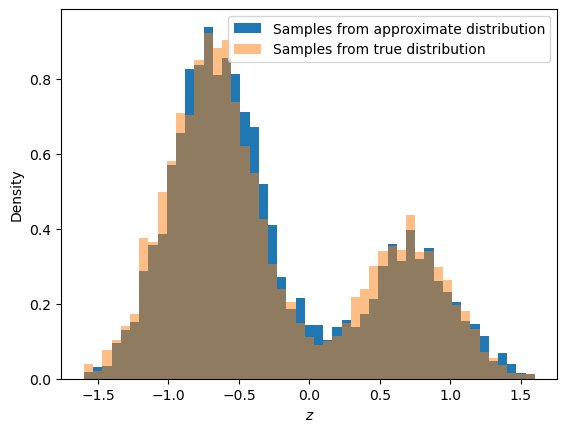

In [10]:
bins = np.linspace(-1.6, 1.6, 50)

plt.hist(np.array(z.ravel(), float), bins=bins, density=True, label='Samples from approximate distribution')
plt.hist(generated_samples.ravel(), bins=bins, alpha=.5, density=True, label="Samples from true distribution")
plt.xlabel('$z$')
plt.ylabel('Density')
plt.legend()
plt.show()

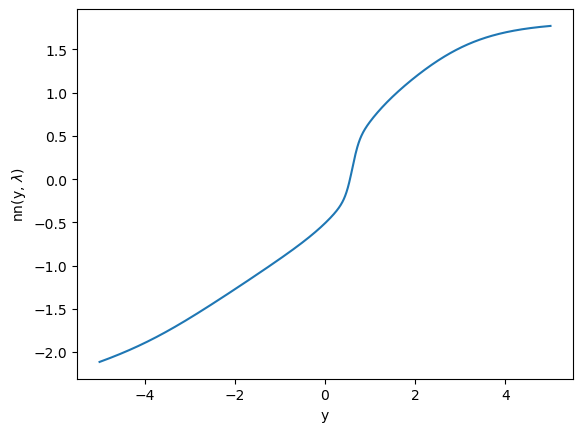

In [11]:
y = np.vstack(np.linspace(-5, 5, 1000))
z = nn(y, lmbda)

plt.plot(y.ravel(), np.array(z.ravel()))
plt.xlabel('y')
plt.ylabel('nn(y, $\lambda$)')
plt.show()